In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class CentralDifference:
    def __init__(self, dt, init_disp, init_R, k, m):
        self.dt = dt
        self.init_disp = init_disp
        self.k = k
        self.m = m
        
        self.velocity = np.zeros(init_disp.shape)
        self.accel = np.matmul(init_R, inv(self.m))
        
        self.a0 = 1 / dt ** 2
        self.a1 = 1 / 2 * dt
        self.a2 = 2 * self.a0
        self.a3 = 1 / self.a2
        
        self.em = inv(self.a0 * m)
        
        self._get_last(init_disp)
        
    def solve(self, U, R):
        el = R - np.matmul((self.k - self.a2 * self.m), U) - np.matmul(self.a0 * self.m, self.last_pos)
        nU = np.matmul(self.em, el)
        self.accel = self.a0 * (self.last_pos - 2 * U + nU)
        self.velocity = self.a1 * ((-1 * self.last_pos) + nU)
        self.last_pos = U
        return nU
    
    def _get_last(self, pos):
        self.last_pos = pos - self.dt * self.velocity + self.a3 * self.accel
        

In [3]:
raw = np.array([
     3.54627e+08, 4.20673e+06, 8.41346e+06,-2.35577e+08, 5.04808e+06, 1.00962e+07,     -168269, 3.36538e+06,           0,-1.17536e+08,-1.26202e+07, 1.68269e+06,     -673077,           0, 6.73077e+06,-1.18041e+08,      841346,-2.52404e+07, 1.17368e+08,     -841346,-1.68269e+06,           0,           0,           0,
 4.20673e+06, 1.02855e+08,      420673, 3.36538e+06,-6.73077e+07,           0, 5.04808e+06,     -588942,      504808,-1.26202e+07,-3.36118e+07,     84134.6,           0,     -673077,      336538,     -841346,-3.36959e+07,    -84134.6,      841346, 3.30228e+07,-1.26202e+06,           0,           0,           0,
 8.41346e+06,      420673, 1.04748e+08, 6.73077e+06,           0,-6.73077e+07,           0,      336538,     -168269,-1.68269e+06,    -84134.6,-3.25601e+07, 1.00962e+07,      504808,-2.35577e+06,-2.52404e+07,     84134.6,-3.47476e+07, 1.68269e+06,-1.26202e+06, 3.23918e+07,           0,           0,           0,
-2.35577e+08, 3.36538e+06, 6.73077e+06, 2.36418e+08,-8.41346e+06,-1.68269e+07,           0,           0,           0,     -168269, 5.04808e+06,           0,           0,           0,           0,     -673077,           0, 1.00962e+07,           0,           0,           0,           0,           0,           0,
 5.04808e+06,-6.73077e+07,           0,-8.41346e+06, 6.85697e+07,      841346,           0,           0,           0, 3.36538e+06,     -588942,     -336538,           0,           0,           0,           0,     -673077,     -504808,           0,           0,           0,           0,           0,           0,
 1.00962e+07,           0,-6.73077e+07,-1.68269e+07,      841346, 6.98317e+07,           0,           0,           0,           0,     -504808,     -168269,           0,           0,           0, 6.73077e+06,     -336538,-2.35577e+06,           0,           0,           0,           0,           0,           0,
     -168269, 5.04808e+06,           0,           0,           0,           0, 2.36418e+08,-8.41346e+06, 1.68269e+07,-2.35577e+08, 3.36538e+06,-6.73077e+06,           0,           0,           0,           0,           0,           0,     -673077,           0,-1.00962e+07,           0,           0,           0,
 3.36538e+06,     -588942,      336538,           0,           0,           0,-8.41346e+06, 6.85697e+07,     -841346, 5.04808e+06,-6.73077e+07,           0,           0,           0,           0,           0,           0,           0,           0,     -673077,      504808,           0,           0,           0,
           0,      504808,     -168269,           0,           0,           0, 1.68269e+07,     -841346, 6.98317e+07,-1.00962e+07,           0,-6.73077e+07,           0,           0,           0,           0,           0,           0,-6.73077e+06,      336538,-2.35577e+06,           0,           0,           0,
-1.17536e+08,-1.26202e+07,-1.68269e+06,     -168269, 3.36538e+06,           0,-2.35577e+08, 5.04808e+06,-1.00962e+07, 3.54627e+08, 4.20673e+06,-8.41346e+06,           0,           0,           0, 1.17368e+08,     -841346, 1.68269e+06,-1.18041e+08,      841346, 2.52404e+07,     -673077,           0,-6.73077e+06,
-1.26202e+07,-3.36118e+07,    -84134.6, 5.04808e+06,     -588942,     -504808, 3.36538e+06,-6.73077e+07,           0, 4.20673e+06, 1.02855e+08,     -420673,           0,           0,           0,      841346, 3.30228e+07, 1.26202e+06,     -841346,-3.36959e+07,     84134.6,           0,     -673077,     -336538,
 1.68269e+06,     84134.6,-3.25601e+07,           0,     -336538,     -168269,-6.73077e+06,           0,-6.73077e+07,-8.41346e+06,     -420673, 1.04748e+08,           0,           0,           0,-1.68269e+06, 1.26202e+06, 3.23918e+07, 2.52404e+07,    -84134.6,-3.47476e+07,-1.00962e+07,     -504808,-2.35577e+06,
     -673077,           0, 1.00962e+07,           0,           0,           0,           0,           0,           0,           0,           0,           0, 2.36418e+08, 8.41346e+06,-1.68269e+07,-2.35577e+08,-3.36538e+06, 6.73077e+06,     -168269,-5.04808e+06,           0,           0,           0,           0,
           0,     -673077,      504808,           0,           0,           0,           0,           0,           0,           0,           0,           0, 8.41346e+06, 6.85697e+07,     -841346,-5.04808e+06,-6.73077e+07,           0,-3.36538e+06,     -588942,      336538,           0,           0,           0,
 6.73077e+06,      336538,-2.35577e+06,           0,           0,           0,           0,           0,           0,           0,           0,           0,-1.68269e+07,     -841346, 6.98317e+07, 1.00962e+07,           0,-6.73077e+07,           0,      504808,     -168269,           0,           0,           0,
-1.18041e+08,     -841346,-2.52404e+07,     -673077,           0, 6.73077e+06,           0,           0,           0, 1.17368e+08,      841346,-1.68269e+06,-2.35577e+08,-5.04808e+06, 1.00962e+07, 3.54627e+08,-4.20673e+06, 8.41346e+06,-1.17536e+08, 1.26202e+07, 1.68269e+06,     -168269,-3.36538e+06,           0,
      841346,-3.36959e+07,     84134.6,           0,     -673077,     -336538,           0,           0,           0,     -841346, 3.30228e+07, 1.26202e+06,-3.36538e+06,-6.73077e+07,           0,-4.20673e+06, 1.02855e+08,     -420673, 1.26202e+07,-3.36118e+07,    -84134.6,-5.04808e+06,     -588942,     -504808,
-2.52404e+07,    -84134.6,-3.47476e+07, 1.00962e+07,     -504808,-2.35577e+06,           0,           0,           0, 1.68269e+06, 1.26202e+06, 3.23918e+07, 6.73077e+06,           0,-6.73077e+07, 8.41346e+06,     -420673, 1.04748e+08,-1.68269e+06,     84134.6,-3.25601e+07,           0,     -336538,     -168269,
 1.17368e+08,      841346, 1.68269e+06,           0,           0,           0,     -673077,           0,-6.73077e+06,-1.18041e+08,     -841346, 2.52404e+07,     -168269,-3.36538e+06,           0,-1.17536e+08, 1.26202e+07,-1.68269e+06, 3.54627e+08,-4.20673e+06,-8.41346e+06,-2.35577e+08,-5.04808e+06,-1.00962e+07,
     -841346, 3.30228e+07,-1.26202e+06,           0,           0,           0,           0,     -673077,      336538,      841346,-3.36959e+07,    -84134.6,-5.04808e+06,     -588942,      504808, 1.26202e+07,-3.36118e+07,     84134.6,-4.20673e+06, 1.02855e+08,      420673,-3.36538e+06,-6.73077e+07,           0,
-1.68269e+06,-1.26202e+06, 3.23918e+07,           0,           0,           0,-1.00962e+07,      504808,-2.35577e+06, 2.52404e+07,     84134.6,-3.47476e+07,           0,      336538,     -168269, 1.68269e+06,    -84134.6,-3.25601e+07,-8.41346e+06,      420673, 1.04748e+08,-6.73077e+06,           0,-6.73077e+07,
           0,           0,           0,           0,           0,           0,           0,           0,           0,     -673077,           0,-1.00962e+07,           0,           0,           0,     -168269,-5.04808e+06,           0,-2.35577e+08,-3.36538e+06,-6.73077e+06, 2.36418e+08, 8.41346e+06, 1.68269e+07,
           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,     -673077,     -504808,           0,           0,           0,-3.36538e+06,     -588942,     -336538,-5.04808e+06,-6.73077e+07,           0, 8.41346e+06, 6.85697e+07,      841346,
           0,           0,           0,           0,           0,           0,           0,           0,           0,-6.73077e+06,     -336538,-2.35577e+06,           0,           0,           0,           0,     -504808,     -168269,-1.00962e+07,           0,-6.73077e+07, 1.68269e+07,      841346, 6.98317e+07,

])
global_stiffness = raw.reshape(24, 24)

def solve_linear_tetrahedral(U):
    return np.matmul(global_stiffness, U)

In [4]:
%%markdown
### Some Debugging...
Currently, my code seems to grow without bound when I run the solver despite the system reaching equilibrium in the basic test below:

### Some Debugging...
Currently, my code seems to grow without bound when I run the solver despite the system reaching equilibrium in the basic test below:


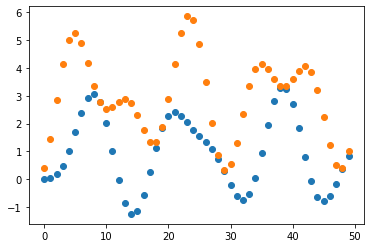

In [5]:
init_disp = np.array([0, 0])
init_R = np.array([0, 10])
k = np.array([[6, -2], [-2, 4]])
m = np.array([[2, 0], [0, 1]])
cd = CentralDifference(0.28, init_disp, init_R, k, m)

U = np.array([0, 0])
R = np.array([0, 10])
results = []
n = 50
for i in range(n):
    U = cd.solve(U, R)
    results.append(U)
    
x = [i for i in range(n)]
    
results = np.array(results)
plt.scatter(x, results[:, 0])
plt.scatter(x, results[:, 1])
plt.show()

In [6]:
%%markdown
### Now
I intend to roll together the linear solver and put the book tetrahedrals from Matlab finite elements and see if we get a similar wavy result.

### Now
I intend to roll together the linear solver and put the book tetrahedrals from Matlab finite elements and see if we get a similar wavy result.


In [18]:
U = np.zeros(24)
R = np.zeros(24)
m = np.identity(24)
cd = CentralDifference(1e-2, U, R, global_stiffness, m)
U = np.array([0,
           0,
           0,
           0,
           0,
           0,
-3.49318e-09,
 6.08193e-06,
 9.03333e-08,
-1.27004e-07,
 6.07812e-06,
 5.55053e-08,
           0,
           0,
           0,
           0,
           0,
           0,
 1.27024e-07,
 6.07813e-06,
 -5.5515e-08,
 3.51326e-09,
 6.08193e-06,
-9.03431e-08,
])

R = solve_linear_tetrahedral(U)
R

array([-3.13293993e+01, -5.34920138e+00, -9.32854007e+00,  3.07042068e+01,
       -4.02575651e+00, -3.07762342e+00, -9.10055990e-05,  3.12502589e+00,
       -2.30171200e-06,  1.93119728e-04,  6.25212990e+00,  1.50151556e-05,
       -3.07042607e+01, -4.02583297e+00,  3.07763010e+00,  3.13295103e+01,
       -5.34973999e+00,  9.32853158e+00, -2.37272126e-04,  6.25335396e+00,
       -9.29840320e-06,  7.79416880e-05,  3.12442418e+00, -1.60315700e-06])

In [19]:
%%markdown
### Success! Sorta...
We have proven that we can reproduce the results from the matlab book, now we can run our solver for a few rounds and see what we get...

### Success! Sorta...
We have proven that we can reproduce the results from the matlab book, now we can run our solver for a few rounds and see what we get...


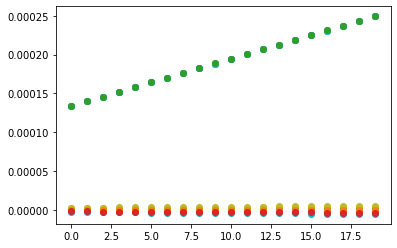

In [22]:
results = []
n = 20
for i in range(n):
    U = cd.solve(U, R)
    R = solve_linear_tetrahedral(U)
    results.append(U)
    
x = [i for i in range(n)]
    
results = np.array(results)
m = results.max(axis=1)
for i in range(results.shape[1]):
    plt.scatter(x, results[:, i])
plt.show()

In [23]:
%%markdown
# Oof

Not so good... Looks like we have a subsection continuing to explode despite the solver being correctly integrated... So, why would this be happening?

# Oof

Not so good... Looks like we have a subsection continuing to explode despite the solver being correctly integrated... So, why would this be happening?
